# 초기 세팅

In [1]:
import os
import subprocess

import numpy as np
import pandas as pd
import matplotlib as mpl 
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

print(f'matplotlib version : {mpl.__version__}')

c:\Users\temp\miniconda3\envs\rec\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


matplotlib version : 3.5.2


In [2]:
file_path = os.path.join('..', 'Data', 'ml-latest-small', 'ratings.csv')
ml_small_df = pd.read_csv(file_path, encoding='utf-8')

# 1. Data 전처리 및 Dataset

In [3]:
def encode(data):
    userId_label_encoder = LabelEncoder()
    movieId_label_encoder = LabelEncoder()

    data['encoded_userId'] = userId_label_encoder.fit_transform(data['userId'].values)
    data['encoded_movieId'] = movieId_label_encoder.fit_transform(data['movieId'].values)
    
    return data, userId_label_encoder, movieId_label_encoder

ml_small_df, userId_label_encoder, movieId_label_encoder = encode(ml_small_df)

In [4]:
class CustomDataset(Dataset):
    def __init__(self, data, train = True, train_size=0.8):

        self._all_data = data
        
        self.num_users = len(self._all_data['encoded_userId'].unique())
        self.num_movies = len(self._all_data['encoded_movieId'].unique())
        
        self.data = self._data_split(train, train_size)
        self.matrix = self._make_matrix(train)

    
    def _make_matrix(self, train):
        users = np.array(self.data['encoded_userId'].values)
        movies = np.array(self.data['encoded_movieId'].values)
        ratings = np.array(self.data['rating'].values)

        if train:
            # 평점의 최저점은 0.5이다.
            # forward 시 곱셈에 영향을 안 주기 위해서 0으로 설정해야하지 않나??
            # 0으로 하면 성능이 구데기로 나오네...
            matrix = np.zeros((self.num_movies, self.num_users))
        else:
            matrix = np.zeros((self.num_movies, self.num_users)) + 3
        
        for user, movie, rating in zip(users, movies, ratings):
            matrix[movie][user] = rating

        return matrix

    
    def _data_split(self, train, train_size):
        train_data, test_data = train_test_split(
            self._all_data, 
            test_size=1-train_size, 
            train_size=train_size, 
            stratify = self._all_data['encoded_userId'].values, 
            random_state=42)

        if train:
            return train_data
        else:
            return test_data

    
    def __len__(self):
        return self.matrix.shape[0]
    

    def __getitem__(self, idx):
        return torch.tensor(self.matrix[idx]).float()
        

In [5]:
ml_small_train_dataset = CustomDataset(data=ml_small_df, train=True, train_size=0.9)
ml_small_test_dataset =  CustomDataset(data=ml_small_df, train=False, train_size=0.9)

# 2. DataLoader

In [6]:
batch_size = 512

train_iter = DataLoader(dataset=ml_small_train_dataset, batch_size=batch_size, shuffle=True)
test_iter = DataLoader(dataset=ml_small_test_dataset, batch_size=batch_size, shuffle=False)

# 3. Model

In [7]:
class AutoRec(nn.Module):
    """
    Item-based AutoRec
    논문에서 encoder의 활성함수로 sigmoid, decoder의 활성함수로 identity 사용
    """
    def __init__(self, num_hiddens, num_users):
        super(AutoRec, self).__init__()
        self.encoder = nn.Sequential(
                                        nn.Linear(in_features=num_users, out_features=num_hiddens, bias=True),
                                        nn.Sigmoid(),
                                    )
        self.decoder = nn.Sequential(
                                        nn.Linear(in_features=num_hiddens, out_features=num_users, bias=True),
                                        nn.Identity(),
                                    )
        
        self.model = nn.ModuleList([self.encoder, self.decoder])
    

    def _init_weights(self):
        for m in self.model.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight.data, mean=0.0, std=0.01)
                if m.bias is not None:
                    m.bias.data.fill_(0.0)

    
    def forward(self, batch_data):
        operand = batch_data

        for operation in self.model:
            result = operation(operand)
            operand = result
        
        return result

In [8]:
class AutoRec_loss_fn(nn.Module):
    """
    AutoRec_loss_fn
    
    Args:
        - loss_fn: (nn.Module) 사용할 Loss Function
    Shape:
        - Input1: (torch.Tensor) Model의 예측 결과. Shape: (batch size,)
        - Input2: (torch.Tensor) 정답. Shape: (batch size,)
        - Output: (torch.Tensor) Observable한 데이터에 대해서만 계산한 Loss. Shape: ()
    """
    def __init__(self, loss_fn):
        super(AutoRec_loss_fn, self).__init__()
        self.loss_fn = loss_fn
    
    def forward(self, pred, y):
        y_for_compute = y.clone().to('cpu')
        index =  np.where(y_for_compute > 0)
        loss = self.loss_fn(pred[index], y[index])
        return loss

# 4. 학습

In [9]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Use {device}')

num_epochs = 100
learning_rate = 1e-3
num_hiddens = 500
weight_decay = 1e-6
num_users = len(ml_small_df['encoded_userId'].unique())

model = AutoRec(num_hiddens=num_hiddens, num_users=num_users)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = AutoRec_loss_fn(nn.MSELoss()).to(device)

Use cuda:0


In [10]:
def funcTrain(model, train_iter, criterion, optimizer, device):
    model.train() # to train mode
    total_train_loss = 0

    for train_matrix in train_iter:
        train_matrix = train_matrix.to(device)

        prediction = model(train_matrix)

        train_loss = criterion(prediction, train_matrix)

        # Update
        optimizer.zero_grad()   # reset gradient 
        train_loss.backward()   # backpropagate
        optimizer.step()        # optimizer update
        
        total_train_loss += train_loss.item()
    
    loss_avg = total_train_loss / len(train_iter)

    return loss_avg

In [11]:
def funcEval(model, test_iter, criterion, device):
    model.eval()
    total_test_loss = 0
    with torch.no_grad():
        for test_matrix in test_iter:
            test_matrix = test_matrix.to(device)

            prediction = model(test_matrix)

            test_loss = criterion(prediction, test_matrix)

            total_test_loss += test_loss.item()
    return total_test_loss / len(test_iter)            

In [12]:
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    
    train_loss = funcTrain(model, train_iter, criterion, optimizer, device)
    test_loss = funcEval(model, test_iter, criterion, device)

    train_losses.append(train_loss)
    test_losses.append(test_loss)

    print(f'epoch: {epoch + 1}, train Loss: {train_loss:.4f}, test Loss: {test_loss:.4f}')

epoch: 1, train Loss: 4.2867, test Loss: 5.5672
epoch: 2, train Loss: 1.1146, test Loss: 1.1321
epoch: 3, train Loss: 0.8149, test Loss: 1.5270
epoch: 4, train Loss: 0.7491, test Loss: 1.4358
epoch: 5, train Loss: 0.7165, test Loss: 1.4480
epoch: 6, train Loss: 0.6975, test Loss: 1.5922
epoch: 7, train Loss: 0.6783, test Loss: 1.6724
epoch: 8, train Loss: 0.6597, test Loss: 1.7151
epoch: 9, train Loss: 0.6420, test Loss: 1.8647
epoch: 10, train Loss: 0.6242, test Loss: 1.9130
epoch: 11, train Loss: 0.6063, test Loss: 1.9415
epoch: 12, train Loss: 0.5862, test Loss: 1.9299
epoch: 13, train Loss: 0.5673, test Loss: 1.9768
epoch: 14, train Loss: 0.5481, test Loss: 2.0712
epoch: 15, train Loss: 0.5299, test Loss: 2.0250
epoch: 16, train Loss: 0.5108, test Loss: 2.1016
epoch: 17, train Loss: 0.4926, test Loss: 2.0405
epoch: 18, train Loss: 0.4746, test Loss: 2.0785
epoch: 19, train Loss: 0.4566, test Loss: 2.1049
epoch: 20, train Loss: 0.4391, test Loss: 2.0627
epoch: 21, train Loss: 0.4215

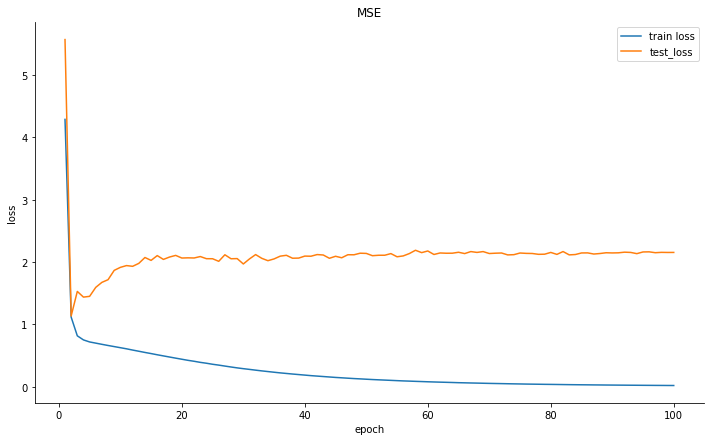

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(12, 7))

x = [i for i in range(1, num_epochs + 1)]

ax.plot(x, train_losses,
          label='train loss')
ax.plot(x, test_losses,
          label='test_loss')

ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_title('MSE')
ax.legend()

ax.spines['top'].set_visible(False) # 위 테두리 안 보이게
ax.spines['right'].set_visible(False) # 오른쪽 테두리 안 보이게

plt.show()